In [46]:
import numpy as np
from scipy.stats import uniform, norm, t, f, kstest
import matplotlib.pyplot as plt
import random

def make_selection(N = 50):
    selection = []
    for _ in range(N):
        element = []
        for _ in range(5):
            element.append(uniform.rvs(-1, 2))
        element.append(norm.rvs(2 + 3 * element[0] - 2 * element[1] + element[2] + \
                       element[3] - element[4], 1.5))
        selection.append(element)
    return np.array(selection)

def print_selection(selection):
    print("Выборка:")
    for s in selection:
        for e in s:
            print(round(e, 4), end=" ")
        print()

def make_regression(ksi, Y):
    # нахождение коэффициентов регрессии
    Psi = []
    for i in range(len(ksi)):
        Psi.append([1] + [ksi[i][j] for j in range(len(ksi[i]))])
    Psi = np.array(Psi)
    Y = np.array(Y)
    F = np.dot(Psi.transpose(), Psi)
    F_1 = np.linalg.inv(F)
    betta_est = np.dot(np.dot(F_1, Psi.transpose()), Y)
    e = np.dot(Psi, betta_est) - Y
    RSS = np.dot(e.transpose(), e)
    return betta_est, RSS, F

def significance_regression_coefficients(betta_est, n, RSS, F):
    p = len(betta_est)
    F_1 = np.linalg.inv(F)
    p_values = []
    for i in range(p):
        delta = betta_est[i] / (RSS * F_1[i][i]) ** 0.5 * (n - p) ** 0.5
        p_value = t.cdf(-abs(delta), n - p) * 2
        p_values.append(p_value)
    
    n = len(betta_est)
    pairs = dict(zip(p_values, zip(betta_est, [i for i in range(1, n + 1)])))
    alpha = 0.05
    for p_value in sorted(list(pairs.keys())):
        if p_value > alpha / n:
            print(f"""Коэффициент регрессии: {round(pairs[p_value][0], 3)}, номер: {pairs[p_value][1]},
                p-value = {round(p_value, 10)}, alpha = {round(alpha / n, 4)}: значим""")
        else:
            print(f"""Коэффициент регрессии: {round(pairs[p_value][0], 3)}, номер: {pairs[p_value][1]}, 
                p-value = {round(p_value, 10)}, alpha = {round(alpha / n, 4)}: не значим""")
            n -= 1
        
    return p_values


def check_multicollinearity(ksi):
    ksi = np.array(ksi)
    for i in range(len(ksi[0])):
        ksi_i = np.delete(ksi, i, 1)
        y = ksi[:, i]
        betta_est, RSS, F = make_regression(ksi_i, y)
        y_aver = sum(y) / len(y)
        TSS = sum([(u - y_aver) ** 2 for u in y])
        R_2 = (TSS - RSS) / TSS
        print("Переменная номер", i + 1, ", R**2 =", round(R_2, 3), end=", ")
        if R_2 < 0.7:
            print("не", end=" ")   
        print("существенно связана с остальными")
        
def check_regression_significance(Y, RSS, n, p):
    y_aver = sum(Y) / len(Y)
    TSS = sum([(y - y_aver) ** 2 for y in Y])
    R_2 = (TSS - RSS) / TSS
    delta = R_2 / (1 - R_2) * (n - p) / (p - 1)
    p_value = 1 - f.cdf(delta, p - 1, n - p)
    print(f"Значимость регресии: delta = {delta}, p-value = {p_value}")
    print("Коэффициент детерминации:", R_2)
    
def forecast(x0, betta_est, F, n, p, RSS):
    Psi0 = np.array(([1] + [x for x in x0]))
    y0 = np.dot(Psi0, betta_est)
    F_1 = np.linalg.inv(F) # ?????
    kappa = (1 + np.dot(np.dot(Psi0, F_1), Psi0.transpose())) ** 0.5
    quartile = t.ppf(0.975, n - p)
    temp = kappa * RSS ** 0.5 / (n - p) ** 0.5
    a = y0 - quartile * temp
    b = y0 + quartile * temp
    print(f"Прогноз: y0 = {y0}, доверительный интервал: {round(a, 3)} < etta0 < {round(b, 3)}")
    
def check_randomness_errors(Y, ksi, betta_est, n):
    e = []
    for i in range(len(Y)):
        ei = Y[i] - betta_est[0] - np.dot(betta_est[1:], ksi[0])
        e.append(ei)
    I = 0
    for i in range(len(e)):
        for j in range(i):
            if e[j] > e[i]:
                I += 1
    delta = (I - n * (n - 1) / 4) / (n ** 3 / 36) ** 0.5
    p_value = 1 - norm.cdf(delta)
    print(f"""Гипотеза о случайности ошибок измерения: 
            p-value = {p_value}, delta = {delta}, I = {I}
            H0: выборка получена из одного закона рспределения и элементы независимы""")
    
def emp_func(xn):
    delta = (max(xn) - min(xn)) / len(xn)
    dots =  sorted(xn)
    func = [i / len(xn) for i in range(len(dots))]
    return dict(zip(dots, func))

def K(x, k):
    res = 1
    for i in range(k):
        res += 2 * (-1) ** k * np.exp(-2 * k ** 2 * x ** 2)
    return res
    
def check_normality_errors(Y, n):
    e = []
    for i in range(len(Y)):
        ei = Y[i] - betta_est[0] - np.dot(betta_est[1:], ksi[0])
        e.append(ei)
    plt.scatter(Y, e)
        
    e_aver = sum(e) / len(e)
    sigma_est = (sum([(ei - e_aver) ** 2 for ei in e]) / (n - 1)) ** 0.5
    dots_func = emp_func(e)
    delta = n ** 0.5 * max([abs(dots_func[ei] - norm.cdf(ei, 0, sigma_est)) for ei in e])
    p_value = 1 - K(delta, 1000)
    print(f"""Гипотеза о нормальности ошибок измерения: 
            p-value = {p_value}, delta = {delta}, sigma_est = {sigma_est}
            H0: ошибки имеют нормальный закон распределения с параметрами (0, sigma ** 2)""")
    print("p-value =", kstest(e, norm.cdf, args=(0, sigma_est))[1])
    
def cross_validation(Y, ksi):
    CVSS = []
    ksi = np.array(ksi)
    Y = np.array(Y)
    for i in range(len(Y)):
        betta_est, RSS, F = make_regression(np.delete(ksi, i, 0), np.delete(Y, i, 0))
        Psi0 = np.array(([1] + [x for x in ksi[i]]))
        y0 = np.dot(Psi0, betta_est)
        CVSS.append((Y[i] - y0) ** 2)
    print("Кросс-проверка")
    print("CVSS =", sum(CVSS))
    
    y_aver = sum(Y) / len(Y)
    TSS = sum([(y - y_aver) ** 2 for y in Y])
    print("R_CV ** 2 =", (TSS - sum(CVSS)) / TSS)
    
def check_adequacy(RSS, n, p, k=5):
    dot = []
    for _ in range(5):
        dot.append(uniform.rvs(-1, 2))
    y = []
    for _ in range(k):
        y.append(norm.rvs(2 + 3 * dot[0] - 2 * dot[1] +dot[2] + \
                   dot[3] - dot[4], 1.5))
    y_aver = sum(y) / len(y)
    S_2 = sum([(y_aver - yi) ** 2 for yi in y]) / (k - 1)
    delta = RSS / (n - p) / S_2
    p_value = 1 - f.cdf(delta, n - p, k - 1)
    print(f"Проверка адекватности: delta = {delta}, p-value = {p_value}")
    
def del_var(selection, var_num, N):
    Y = [selection[i][-1] for i in range(len(selection))]
    selection = np.delete(np.array(selection), var_num, 1)
    ksi = np.delete(np.array(selection), len(selection[0]) - 1, 1)
    betta_est, RSS, F = make_regression(ksi, Y)
    print("Оценка коэффициентов регрессии:")
    print(betta_est)
    significance_regression_coefficients(betta_est, N, RSS, F)
    check_regression_significance(Y, RSS, N, len(ksi[0]))
    return RSS
    
def compare_regressions(RSS0, RSS1, n, p0, p1):
    delta = (RSS0 - RSS1) / RSS1 * (n - p1) / (p1 - p0)
    p_value = 1 - f.cdf(delta, p1 - p0, n - p1)
    print(f"Сравнение двух регрессий: delta = {delta}, p_value = {p_value}")
    
def compare_regressions_bootstrap(selection, var_num, N=1000):
    selection0 = np.delete(np.array(selection), var_num, 1)
    deltas = []
    n = len(selection)
    for _ in range(N):
        numbers = []
        for _ in range(n):
            numbers.append(random.randint(0, n - 1))
            
        temp_select = [selection[i] for i in numbers]
        temp_select0 = [selection0[i] for i in numbers]
        
        Y = [temp_select[i][-1] for i in range(len(temp_select))]
        ksi = [[e for e in s[:-1]] for s in temp_select]
        Y0 = [temp_select0[i][-1] for i in range(len(temp_select0))]
        ksi0 = [[e for e in s[:-1]] for s in temp_select0]
        
        betta_est, RSS, F = make_regression(ksi, Y)
        betta_est0, RSS0, F0 = make_regression(ksi0, Y0)
        
        p1 = len(temp_select[0])
        p0 = len(temp_select0[0])
        
        deltas.append((RSS0 - RSS) / RSS * (n - p1) / (p1 - p0))
        
    deltas = sorted(deltas)
    
    Y = [selection[i][-1] for i in range(len(selection))]
    ksi = [[e for e in s[:-1]] for s in selection]
    Y0 = [selection0[i][-1] for i in range(len(selection0))]
    ksi0 = [[e for e in s[:-1]] for s in selection0]
    betta_est, RSS, F = make_regression(ksi, Y)
    betta_est0, RSS0, F0 = make_regression(ksi0, Y0)
        
    p1 = len(selection[0])
    p0 = len(selection0[0])
    
    delta = (RSS0 - RSS) / RSS * (n - p1) / (p1 - p0)
    p_value = sum([1 if d > delta else 0 for d in deltas]) / len(deltas)
    
    print(f"Сравнение двух регрессий (bootstrap): delta = {delta}, p_value = {p_value}")

In [5]:
N = 50
selection = make_selection(N)
# print_selection(selection)

In [39]:
print(len(selection), len(selection[0]))

50 6


In [6]:
Y = [selection[i][-1] for i in range(len(selection))]
ksi = [[e for e in s[:-1]] for s in selection]
betta_est, RSS, F = make_regression(ksi, Y)
print("Оценка коэффициентов регрессии:")
print(betta_est)
significance_regression_coefficients(betta_est, N, RSS, F)

Оценка коэффициентов регрессии:
[ 2.38126232  2.74952225 -1.97424737  0.46745371  0.83612617 -0.93704428]
Коэффициент регрессии: 2.381, номер: 1, 
                p-value = 0.0, alpha = 0.0083: не значим
Коэффициент регрессии: 2.75, номер: 2, 
                p-value = 2.13e-08, alpha = 0.01: не значим
Коэффициент регрессии: -1.974, номер: 3, 
                p-value = 1.898e-06, alpha = 0.0125: не значим
Коэффициент регрессии: -0.937, номер: 6,
                p-value = 0.0197521904, alpha = 0.0167: значим
Коэффициент регрессии: 0.836, номер: 5,
                p-value = 0.0336356675, alpha = 0.0167: значим
Коэффициент регрессии: 0.467, номер: 4,
                p-value = 0.2465508899, alpha = 0.0167: значим


[2.8352323403859977e-14,
 2.13364022378299e-08,
 1.8980451125308784e-06,
 0.24655088985351775,
 0.033635667495261604,
 0.019752190431291953]

In [7]:
check_multicollinearity(ksi)

Переменная номер 1 , R**2 = 0.121, не существенно связана с остальными
Переменная номер 2 , R**2 = 0.02, не существенно связана с остальными
Переменная номер 3 , R**2 = 0.157, не существенно связана с остальными
Переменная номер 4 , R**2 = 0.079, не существенно связана с остальными
Переменная номер 5 , R**2 = 0.177, не существенно связана с остальными


In [8]:
check_regression_significance(Y, RSS, N, len(ksi[0]))

Значимость регресии: delta = 25.146490607716366, p-value = 5.5688897937500315e-11
Коэффициент детерминации: 0.6909042654344564


In [9]:
forecast([0, 0, 0, 0, 0], betta_est, F, N, len(ksi[0]), RSS)

Прогноз: y0 = 2.3812623157526964, доверительный интервал: -0.609 < etta0 < 5.371


In [10]:
check_randomness_errors(Y, ksi, betta_est, N)

Гипотеза о случайности ошибок измерения: 
            p-value = 0.15227638907215302, delta = 1.026719046282867, I = 673
            H0: выборка получена из одного закона рспределения и элементы независимы


Гипотеза о нормальности ошибок измерения: 
            p-value = 0.0, delta = 2.7912779383520596, sigma_est = 2.532315670030363
            H0: ошибки имеют нормальный закон распределения с параметрами (0, sigma ** 2)
p-value = 1.5515153183143751e-07


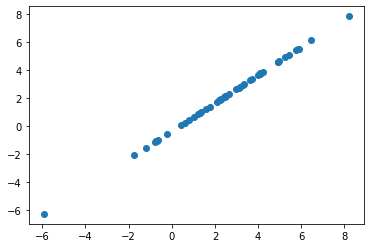

In [11]:
check_normality_errors(Y, N)

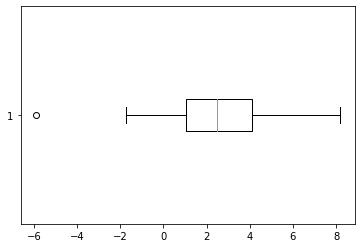

In [12]:
u = plt.boxplot(Y, vert=False)

In [13]:
cross_validation(Y, ksi)

Кросс-проверка
CVSS = 130.11471838657744
R_CV ** 2 = 0.5859100776899308


In [14]:
check_adequacy(RSS, N, len(ksi[0]))

Проверка адекватности: delta = 0.7367587978006125, p-value = 0.7362084432357319


In [31]:
RSS0 = del_var(selection, 1, N)

Оценка коэффициентов регрессии:
[ 2.37127303  3.00251321  0.42607761  0.75838018 -0.82451195]
Коэффициент регрессии: 2.371, номер: 1, 
                p-value = 1e-10, alpha = 0.01: не значим
Коэффициент регрессии: 3.003, номер: 2, 
                p-value = 5.441e-07, alpha = 0.0125: не значим
Коэффициент регрессии: -0.825, номер: 5,
                p-value = 0.1036544981, alpha = 0.0167: значим
Коэффициент регрессии: 0.758, номер: 4,
                p-value = 0.1279086419, alpha = 0.0167: значим
Коэффициент регрессии: 0.426, номер: 3,
                p-value = 0.4085483055, alpha = 0.0167: значим
Значимость регресии: delta = 14.11655285846677, p-value = 1.177228158955046e-06
Коэффициент детерминации: 0.47934150802923375


In [37]:
compare_regressions(RSS0, RSS, N, len(ksi[0]) - 1, len(ksi[0]))

Сравнение двух регрессий: delta = 30.800567651367047, p_value = 1.4471358736889428e-06


In [47]:
compare_regressions_bootstrap(selection, 1)

Сравнение двух регрессий (bootstrap): delta = 30.11611059244778, p_value = 0.519


In [20]:
p = [[1, 2], [3, 4]]
p = np.array(p)
print(p.transpose())
print(np.dot(p, p.transpose()))
print(np.linalg.inv(p))
print(p - p * 5)
print(p * 2)

[[1 3]
 [2 4]]
[[ 5 11]
 [11 25]]
[[-2.   1. ]
 [ 1.5 -0.5]]
[[ -4  -8]
 [-12 -16]]
[[2 4]
 [6 8]]
